# (Step 0) Installation

In [1]:
!pip install zadu
!pip install umap-learn
!pip install umato
!pip install scikit-learn
!pip install bayesian-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 91.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 107.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039183 sha256=8851d103f2a07873c0cf2bbdc72d3ded47d76da117d435700b86c2f275b51a1b
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395103 sha256=f7ae2527bd616c63d6e4fdd490bc25c82abd32b3aaceb801b95de19735b10f17
  Stored in directory: 

# (Step 1) Naive execution

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import umato
import numpy as np

## install data
mnist784 = fetch_openml('mnist_784', version=1, cache=True)
hd = mnist784.data.to_numpy()[::20]
label = mnist784.target.to_numpy()[::20].astype(np.int32)

## generate embeddings
tsne_emb = TSNE(perplexity=25).fit_transform(hd)
pca_emb = PCA().fit_transform(hd)
umap_emb = umap.UMAP(n_neighbors=15).fit_transform(hd)
umato_emb = umato.UMATO(hub_num=300).fit_transform(hd)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


# (Step 1) Naive execution - visualization

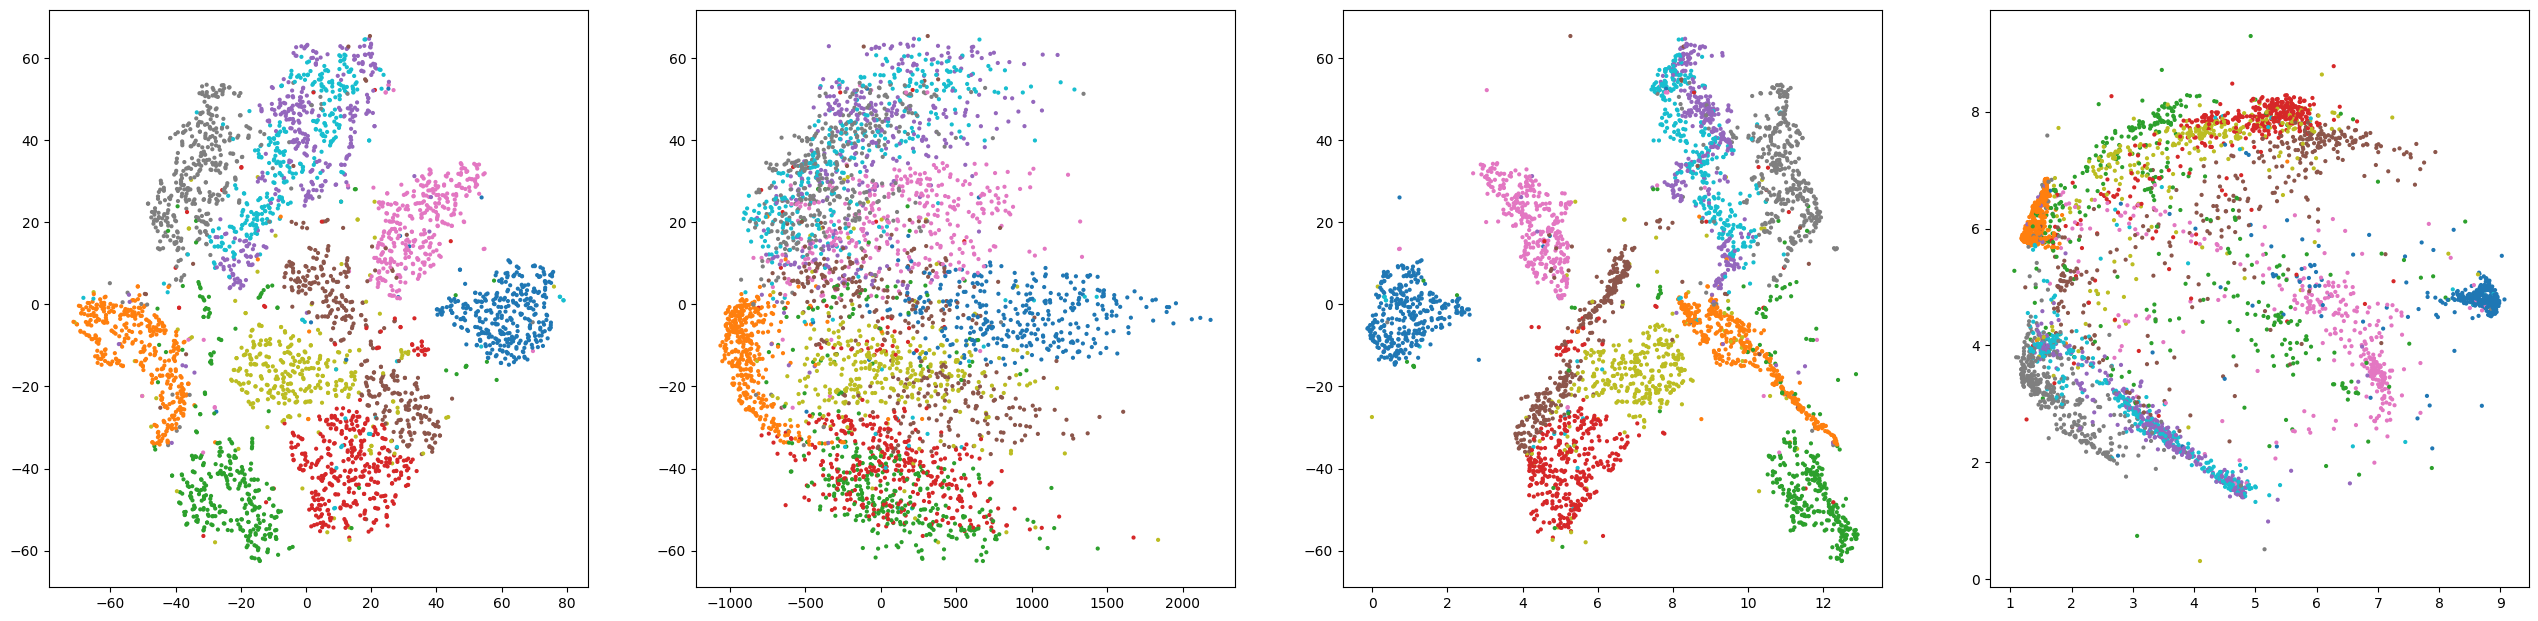

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 4, figsize = (32, 7.5))
ax[0].scatter(x=tsne_emb[:,0], y=tsne_emb[:,1], c=label, s=4, cmap='tab10')
ax[1].scatter(x=pca_emb[:,0], y=tsne_emb[:,1], c=label, s=4, cmap='tab10')
ax[2].scatter(x=umap_emb[:,0], y=tsne_emb[:,1], c=label, s=4, cmap='tab10')
ax[3].scatter(x=umato_emb[:,0], y=umato_emb[:,1], c=label, s=4, cmap='tab10')

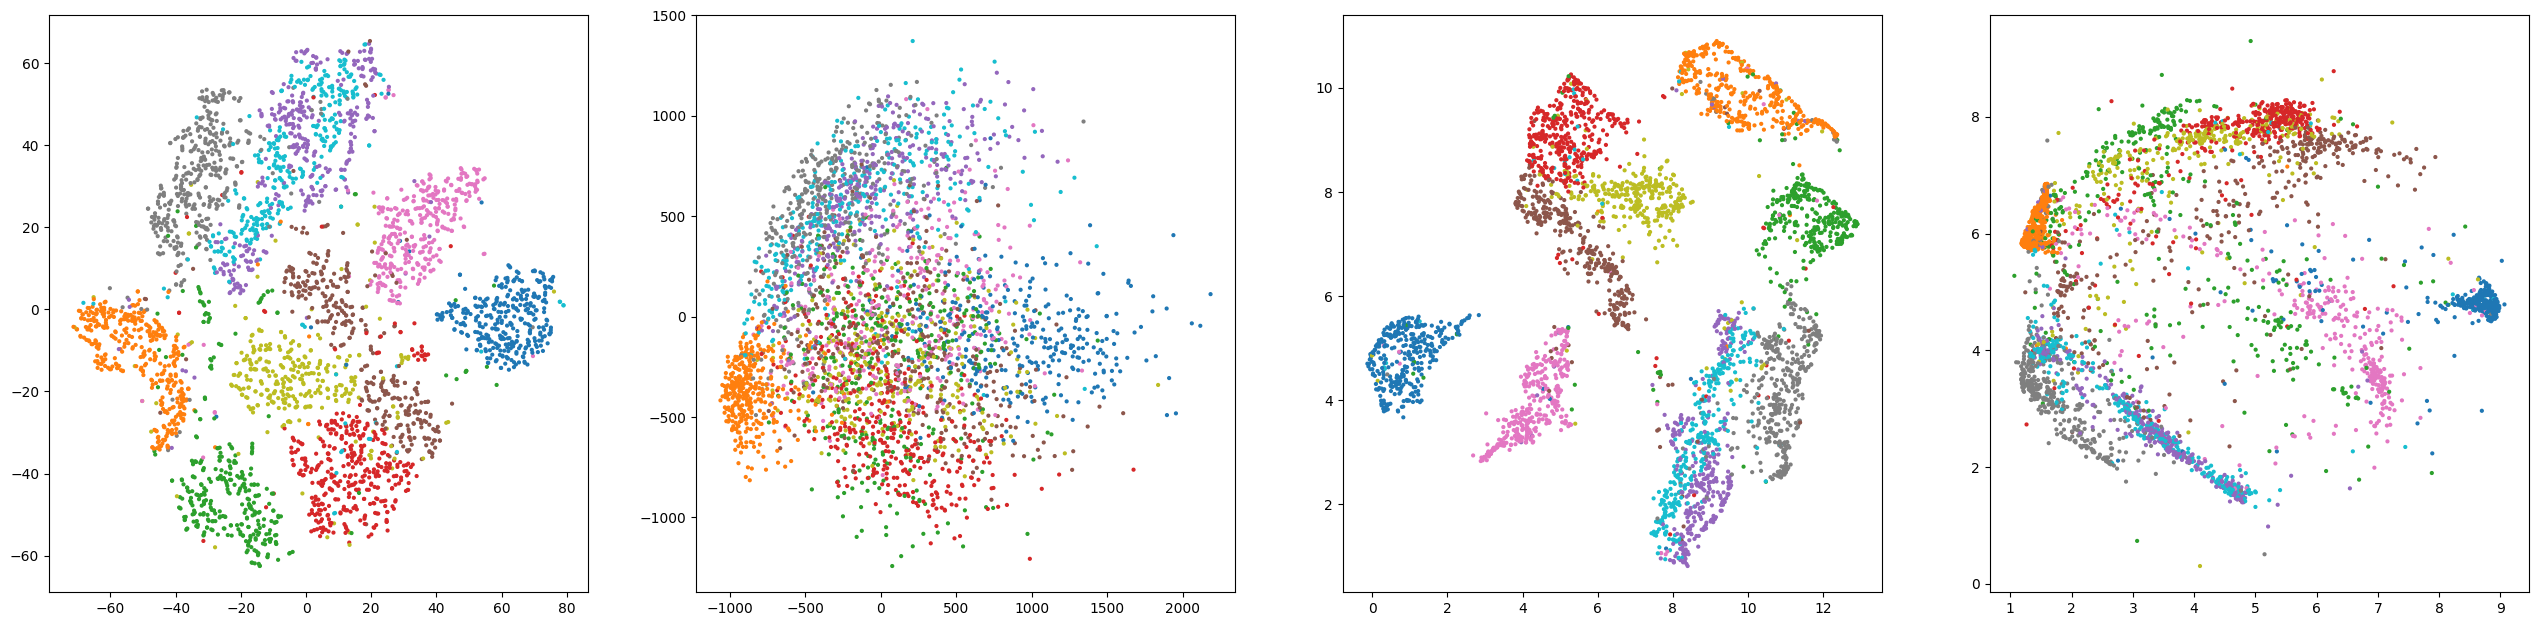

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 4, figsize = (32, 7.5))
ax[0].scatter(x=tsne_emb[:,0], y=tsne_emb[:,1], c=label, s=4, cmap='tab10')
ax[1].scatter(x=pca_emb[:,0], y=pca_emb[:,1], c=label, s=4, cmap='tab10')
ax[2].scatter(x=umap_emb[:,0], y=umap_emb[:,1], c=label, s=4, cmap='tab10')
ax[3].scatter(x=umato_emb[:,0], y=umato_emb[:,1], c=label, s=4, cmap='tab10')

# (Step 2) UMAP Hyperparameter

In [4]:
from tqdm import tqdm

n_neighbors_list = [2, 5, 10, 100]
min_dist_list = [0.01, 0.05, 0.1, 0.5]

umap_grid = []
for n_neighbors in tqdm(n_neighbors_list):
  umap_list = []
  for min_dist in min_dist_list:
    emb = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist).fit_transform(hd)
    umap_list.append(emb)
  umap_grid.append(umap_list)

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
100%|██████████| 4/4 [05:39<00:00, 84.79s/it]


# (Step 2) UMAP Hyperparameter - visualization

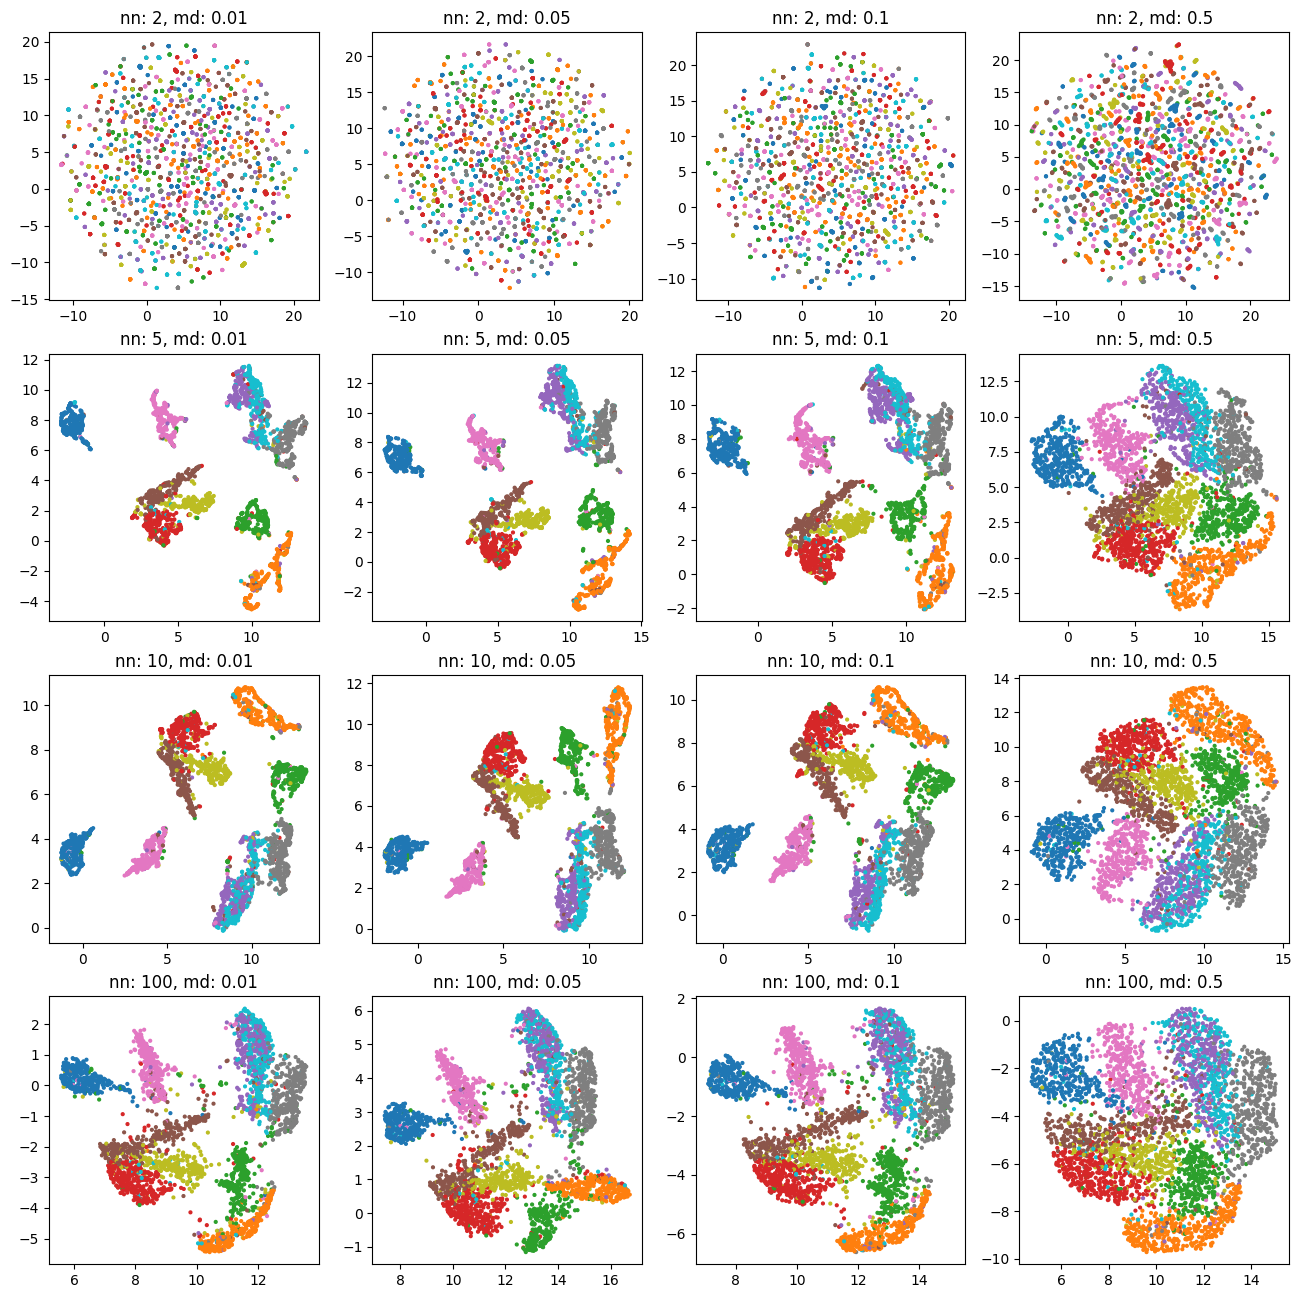

In [6]:
fig, ax = plt.subplots(4, 4, figsize=(16, 16))

for i in range(4):
  for j in range(4):
    ax[i][j].scatter(
        x=umap_grid[i][j][:,0],
        y=umap_grid[i][j][:,1],
        c=label, s=4, cmap='tab10'
    )
    ax[i][j].set_title(f"nn: {n_neighbors_list[i]}, md: {min_dist_list[j]}")

# (Step 3) Distortion Measurement

In [7]:
from zadu import zadu

## initialize  ZADU library
spec = [{
    "id" : "tnc",
    "params" : {
        "k" : 25
    }
}]
zadu_obj = zadu.ZADU(spec, hd, return_local=True)

## evaluate embeddings
global_scores_grid = np.zeros((4,4))
local_scores_grid = []
for i in range(4):
  local_scores_list = []
  for j in range(4):
    global_score, local_score = zadu_obj.measure(umap_grid[i][j])
    local_scores_list.append(local_score)
    global_scores_grid[i][j] = (
        global_score[0]["trustworthiness"] + global_score[0]["continuity"]
    )/2
    local_scores_grid.append(local_scores_list)

# (Step 3) Distortion Measurement - visualizing distortions

In [8]:
from zaduvis import zaduvis

fig, ax = plt.subplots(1, 4, figsize=(50,12.5))

for i in tqdm(range(4)):
  zaduvis.reliability_map(
      umap_grid[i][3],
      local_scores_grid[i][3][0]["local_trustworthiness"],
      local_scores_grid[i][3][0]["local_continuity"],
      k=10,
      ax=ax[i]
  )
  ax[i].set_title(f"nn: {n_neighbors_list[i]}, md: {min_dist_list[3]}")

Output hidden; open in https://colab.research.google.com to view.

# (Step 4) Optimal hyperparameter

In [9]:
from bayes_opt import BayesianOptimization

pbounds = {
    "n_neighbors": (2, 200),
    "min_dist": (0.01, 0.99)
}
zadu_obj = zadu.ZADU(spec, hd, return_local=True)

def optimize_umap(n_neighbors, min_dist):
  n_neighbors = int(n_neighbors)
  min_dist = float(min_dist)
  emb = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist).fit_transform(hd)

  global_score, local_score = zadu_obj.measure(emb)

  score = (global_score[0]["trustworthiness"] + global_score[0]["continuity"]) / 2

  return score

optimizer = BayesianOptimization(
    f=optimize_umap,
    pbounds=pbounds
)

optimizer.maximize(
    init_points=5,
    n_iter=25
)

|   iter    |  target   | min_dist  | n_neig... |
-------------------------------------------------
| 1         | 0.9126    | 0.858     | 152.8     |
| 2         | 0.9266    | 0.6605    | 14.0      |
| 3         | 0.9398    | 0.08048   | 41.06     |
| 4         | 0.9404    | 0.07208   | 21.97     |
| 5         | 0.9131    | 0.7577    | 166.0     |
| 6         | 0.9142    | 0.9832    | 62.74     |
| 7         | 0.9222    | 0.9247    | 31.63     |
| 8         | 0.939     | 0.1842    | 20.69     |
| 9         | 0.9399    | 0.01      | 47.4      |
| 10        | 0.9344    | 0.1925    | 107.9     |
| 11        | 0.9137    | 0.9309    | 96.29     |
| 12        | 0.9379    | 0.01815   | 117.6     |
| 13        | 0.9105    | 0.9637    | 127.6     |
| 14        | 0.9198    | 0.5029    | 200.0     |
| 15        | 0.9119    | 0.981     | 113.1     |
| 16        | 0.9397    | 0.04764   | 44.23     |
| 17        | 0.9188    | 0.9761    | 51.21     |
| 18        | 0.9379    | 0.01      | 120.5     |


In [ ]:
optimal_n_neighbors = int(optimizer.max["params"]["n_neighbors"])
optimal_min_dist = float(optimizer.max["params"]["min_dist"])

opt_umap = umap.UMAP(n_neighbors=optimal_n_neighbors, min_dist=optimal_min_dist).fit_transform(hd)
default_umap = umap.UMAP().fit_transform(hd)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(25, 12.5))

ax[0].scatter(x=opt_umap[:,0], y=opt_umap[:,1], c=label, s=4, cmap='tab10')
ax[1].scatter(x=default_umap[:,0], y=default_umap[:,1], c=label, s=4, cmap='tab10')